<a href="https://colab.research.google.com/github/CaseySobon/Recommendation-system/blob/main/Gradient_Boost_for_decision_trees_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [ ]:
import findspark

findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

from google.colab import files

#uploaded = files.upload()

In [ ]:
uploaded = files.upload()

Saving testTrack_hierarchy.txt to testTrack_hierarchy.txt


In [ ]:
from pyspark.ml.classification import LogisticRegression

spark = SparkSession.builder.appName('recommend-ML').getOrCreate()

df = spark.read.csv('predict_matrix2.csv', header = True, inferSchema = True)

cols = df.columns
df.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ptrack: double (nullable = true)
 |-- palbum: double (nullable = true)
 |-- partist: double (nullable = true)
 |-- min_pgene: double (nullable = true)
 |-- max_pgene: double (nullable = true)
 |-- mean_pgene: double (nullable = true)
 |-- variance_pgene: double (nullable = true)
 |-- stddev_pgene: double (nullable = true)
 |-- Predictor: double (nullable = true)



In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StringIndexerModel

In [ ]:
numericCols = ['ptrack','palbum', 'partist',  'max_pgene']


In [ ]:
result_given = spark.read.csv('test2_new.txt',sep='|' , inferSchema = True)
result_given = result_given.withColumnRenamed('_c0','userID').withColumnRenamed('_c1','trackID').withColumnRenamed('_c2','recommendation')
result_given.show(6)
result_given.select('userID').describe().show()

+------+-------+--------------+
|userID|trackID|recommendation|
+------+-------+--------------+
|200031|  30877|             1|
|200031|   8244|             1|
|200031| 130183|             0|
|200031| 198762|             0|
|200031|  34503|             1|
|200031| 227283|             0|
+------+-------+--------------+
only showing top 6 rows

+-------+-----------------+
|summary|           userID|
+-------+-----------------+
|  count|             6000|
|   mean|       206286.491|
| stddev|3515.749299951101|
|    min|           200031|
|    max|           212234|
+-------+-----------------+



In [ ]:
training =result_given.join(df, ['userID','trackID'],'left').orderBy('userID')


training.show(6)
training.select('userID').describe().show()

+------+-------+--------------+---------+---------+---------+---------+---------+------------------+------------------+------------------+---------+
|userID|trackID|recommendation|   ptrack|   palbum|  partist|min_pgene|max_pgene|        mean_pgene|    variance_pgene|      stddev_pgene|Predictor|
+------+-------+--------------+---------+---------+---------+---------+---------+------------------+------------------+------------------+---------+
|200031| 130183|             0| 81.32569|     20.0|     20.0|59.096783|69.386215| 64.24149894714355|52.936210849795316| 7.275727513437768|      0.0|
|200031|  34503|             1| 58.71226| 44.02513|45.541058|51.372997|  69.2446|61.338722229003906| 50.17851274997812| 7.083679322920972|     90.0|
|200031|  30877|             1|62.391335|50.321358|  50.6686| 45.27148| 67.92092| 58.83158493041992| 83.00489047663285| 9.110701974965094|     90.0|
|200031|   8244|             1|62.807575| 63.34095|47.197838|55.769062| 72.66834|  65.5764274597168| 38.77

In [ ]:

numericCols = ['ptrack','palbum', 'partist',  'max_pgene','mean_pgene' ,  'min_pgene', 'variance_pgene','stddev_pgene','Predictor']

stages = []
assemblerInputs =  numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]




In [ ]:
label_stringIdx = StringIndexer(inputCol = 'recommendation', outputCol = 'label')
stages += [label_stringIdx]


In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(training)
training = pipelineModel.transform(training)
selectedCols = [ 'label','features'] + cols
training = training.select(selectedCols)
training.printSchema()
training.show(3)

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ptrack: double (nullable = true)
 |-- palbum: double (nullable = true)
 |-- partist: double (nullable = true)
 |-- min_pgene: double (nullable = true)
 |-- max_pgene: double (nullable = true)
 |-- mean_pgene: double (nullable = true)
 |-- variance_pgene: double (nullable = true)
 |-- stddev_pgene: double (nullable = true)
 |-- Predictor: double (nullable = true)

+-----+--------------------+------+-------+---------+---------+---------+---------+---------+-----------------+------------------+------------------+---------+
|label|            features|userID|trackID|   ptrack|   palbum|  partist|min_pgene|max_pgene|       mean_pgene|    variance_pgene|      stddev_pgene|Predictor|
+-----+--------------------+------+-------+---------+---------+---------+---------+---------+-----------------+------------------+-----------------

In [ ]:
import pandas as pd
pd.DataFrame(training.take(5), columns=training.columns).transpose()



,0,1,2,3,4
label,1.0,1.0,0.0,1.0,0.0
features,"[62.807575, 63.34095, 47.197838, 72.66834, 65....","[62.391335, 50.321358, 50.6686, 67.92092, 58.8...","[76.56662, 74.93448, 75.091, 71.40223, 67.7001...","[58.71226, 44.02513, 45.541058, 69.2446, 61.33...","[81.32569, 20.0, 20.0, 69.386215, 64.241498947..."
userID,200031,200031,200031,200031,200031
trackID,8244,30877,227283,34503,130183
ptrack,62.807575,62.391335,76.56662,58.71226,81.32569
palbum,63.34095,50.321358,74.93448,44.02513,20.0
partist,47.197838,50.6686,75.091,45.541058,20.0
min_pgene,55.769062,45.27148,62.759956,51.372997,59.096783
max_pgene,72.66834,67.92092,71.40223,69.2446,69.386215
mean_pgene,65.576427,58.831585,67.700188,61.338722,64.241499


In [ ]:
from pyspark.sql.functions import lit

df=df.withColumn('recommendation', lit(0))
df.show(3)

+------+-------+---------+---------+---------+---------+---------+-----------------+-----------------+------------------+---------+--------------+
|userID|trackID|   ptrack|   palbum|  partist|min_pgene|max_pgene|       mean_pgene|   variance_pgene|      stddev_pgene|Predictor|recommendation|
+------+-------+---------+---------+---------+---------+---------+-----------------+-----------------+------------------+---------+--------------+
|199810|   9903| 67.05974|     20.0|     20.0|44.256237|59.234833|50.81350135803223| 48.5295511768442|6.9663154663598315|      0.0|             0|
|199810| 208019|62.093025|56.200005|     20.0|      0.0|      0.0|              0.0|              0.0|               0.0|      0.0|             0|
|199810|  74139| 84.71382| 83.42785|62.185196|25.423084|78.993126|61.31705529349191|364.3708759446474|19.088501144528017|     80.0|             0|
+------+-------+---------+---------+---------+---------+---------+-----------------+-----------------+----------------

In [ ]:

stages = []
assemblerInputs =  numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
label_stringIdx = StringIndexer(inputCol = 'recommendation', outputCol = 'label')
stages += [label_stringIdx]

In [ ]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df_test = pipelineModel.transform(df)
selectedCols = [ 'label','features'] + cols
df_test = df_test.select(selectedCols)
df_test.printSchema()
df_test.show(3)

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ptrack: double (nullable = true)
 |-- palbum: double (nullable = true)
 |-- partist: double (nullable = true)
 |-- min_pgene: double (nullable = true)
 |-- max_pgene: double (nullable = true)
 |-- mean_pgene: double (nullable = true)
 |-- variance_pgene: double (nullable = true)
 |-- stddev_pgene: double (nullable = true)
 |-- Predictor: double (nullable = true)

+-----+--------------------+------+-------+---------+---------+---------+---------+---------+-----------------+-----------------+------------------+---------+
|label|            features|userID|trackID|   ptrack|   palbum|  partist|min_pgene|max_pgene|       mean_pgene|   variance_pgene|      stddev_pgene|Predictor|
+-----+--------------------+------+-------+---------+---------+---------+---------+---------+-----------------+-----------------+------------------+-

In [ ]:
from pyspark.sql.functions import col

train = training.where(col("userID").between(202284, 212234))
test = training.where(col("userID").between(200031, 202277))
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


Training Dataset Count: 4992
Test Dataset Count: 1008


In [ ]:
# logistic regression in pySpark
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)


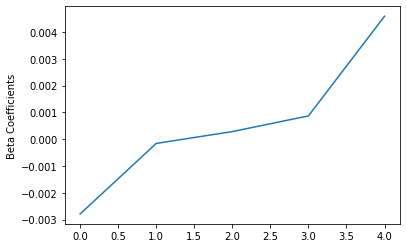

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


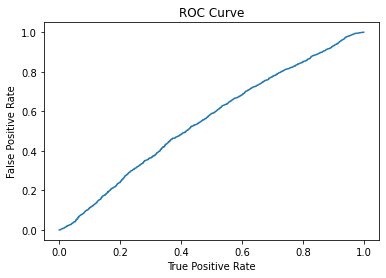

Training set areaUnderROC: 0.5545856543546592


In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=3)
linModel = lr.fit(training)

In [ ]:
predictions = lrModel.transform(df)
predictions.select('userID', 'trackID', 'probability',
                   'rawPrediction', 'prediction' ).show(12)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810|   9903|[0.53649639967141...|[0.14624569860239...|       0.0|
|199810| 208019|[0.53670799532424...|[0.14709664132957...|       0.0|
|199810|  74139|[0.49339995075648...|[-0.0264017304807...|       1.0|
|199810|  18515|[0.48225170450936...|[-0.0710230218499...|       1.0|
|199810| 242681|[0.46996022747477...|[-0.1203039775017...|       1.0|
|199810| 105760|[0.47125468590616...|[-0.1151081858070...|       1.0|
|199812| 211361|[0.55730515151793...|[0.23023223515837...|       0.0|
|199812| 276940|[0.49499170848155...|[-0.0200338361028...|       1.0|
|199812| 142408|[0.45319688947962...|[-0.1877621277528...|       1.0|
|199812| 130023|[0.48589349174265...|[-0.0564410114075...|       1.0|
|199812| 223706|[0.42498620673091...|[-0.3023373151567...|       1.0|
|199812|  29189|[0.4

In [ ]:
sort_predictions = predictions.select('userID', 'trackID',
                                      'label', 'probability',
                                      'rawPrediction', 'prediction'
                                     ).sort(col("userID").asc(), col("probability").desc())
sort_predictions.show(50)



+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|199810| 208019|  0.0|[0.53670799532424...|[0.14709664132957...|       0.0|
|199810|   9903|  0.0|[0.53649639967141...|[0.14624569860239...|       0.0|
|199810|  74139|  0.0|[0.49339995075648...|[-0.0264017304807...|       1.0|
|199810|  18515|  0.0|[0.48225170450936...|[-0.0710230218499...|       1.0|
|199810| 105760|  0.0|[0.47125468590616...|[-0.1151081858070...|       1.0|
|199810| 242681|  0.0|[0.46996022747477...|[-0.1203039775017...|       1.0|
|199812| 211361|  0.0|[0.55730515151793...|[0.23023223515837...|       0.0|
|199812| 276940|  0.0|[0.49499170848155...|[-0.0200338361028...|       1.0|
|199812| 130023|  0.0|[0.48589349174265...|[-0.0564410114075...|       1.0|
|199812|  29189|  0.0|[0.45949143122752...|[-0.1623901967856...|       1.0|
|199812| 142

In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.functions import when,concat_ws
from pyspark.sql.window import *
from pyspark.sql.functions import row_number

predict_f = sort_predictions.withColumn("row_number", f.row_number().over(Window.partitionBy("userID").orderBy("probability")))
predict_f1=predict_f.withColumnRenamed("row_number","Predictor").orderBy("userID")

predict_f1.show(6)
predict_f1=predict_f1.withColumn("Predictor", when(predict_f1.Predictor >= 4,0).otherwise(1))
predict_f1=predict_f1.select(concat_ws('_',predict_f1.userID,predict_f1.trackID).alias("TrackID"),'Predictor').orderBy("userID")
predict_f1.show(6)
print((predict_f1.count(), len(predict_f1.columns)))

+------+-------+-----+--------------------+--------------------+----------+---------+
|userID|trackID|label|         probability|       rawPrediction|prediction|Predictor|
+------+-------+-----+--------------------+--------------------+----------+---------+
|199810| 208019|  0.0|[0.53670799532424...|[0.14709664132957...|       0.0|        6|
|199810|   9903|  0.0|[0.53649639967141...|[0.14624569860239...|       0.0|        5|
|199810| 242681|  0.0|[0.46996022747477...|[-0.1203039775017...|       1.0|        1|
|199810| 105760|  0.0|[0.47125468590616...|[-0.1151081858070...|       1.0|        2|
|199810|  74139|  0.0|[0.49339995075648...|[-0.0264017304807...|       1.0|        4|
|199810|  18515|  0.0|[0.48225170450936...|[-0.0710230218499...|       1.0|        3|
+------+-------+-----+--------------------+--------------------+----------+---------+
only showing top 6 rows

+-------------+---------+
|      TrackID|Predictor|
+-------------+---------+
|199810_208019|        0|
|  199810_9

In [ ]:
predict_f1.toPandas().to_csv('linear_results.csv',index=False)

In [ ]:
df.toPandas().to_csv('full_data.csv',index=False)

In [ ]:
training.toPandas().to_csv('training_data.csv',index=False)

In [ ]:
# decision tree classifier in pySpark

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label',maxDepth = 10)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)

sort_predictions = predictions.select('userID', 'trackID',
                   'label', 'probability',
                   'rawPrediction', 'prediction' ).sort(col("userID").asc(), col("probability").desc())

sort_predictions.show(6)


+------+-------+-----+--------------------+-------------+----------+
|userID|trackID|label|         probability|rawPrediction|prediction|
+------+-------+-----+--------------------+-------------+----------+
|200031| 227283|  0.0|[0.46904024767801...|[303.0,343.0]|       1.0|
|200031|  30877|  1.0|[0.42796610169491...|[202.0,270.0]|       1.0|
|200031|   8244|  1.0|[0.42796610169491...|[202.0,270.0]|       1.0|
|200031| 198762|  0.0|[0.36391437308868...|[357.0,624.0]|       1.0|
|200031| 130183|  0.0|[0.34951456310679...|  [36.0,67.0]|       1.0|
|200031|  34503|  1.0|[0.30434782608695...|   [7.0,16.0]|       1.0|
+------+-------+-----+--------------------+-------------+----------+
only showing top 6 rows



In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions,{evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.6071369520030234


In [ ]:
trainingSummary = dtModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

AttributeError: ignored

In [ ]:
predict_f = sort_predictions.withColumn("row_number", f.row_number().over(Window.partitionBy("userID").orderBy("probability")))
predict_f1=predict_f.withColumnRenamed("row_number","Predictor").orderBy("userID")

predict_f1.show(6)
predict_f1=predict_f1.withColumn("Predictor", when(predict_f1.Predictor >= 4,0).otherwise(1))
predict_f1=predict_f1.select(concat_ws('_',predict_f1.userID,predict_f1.trackID).alias("TrackID"),'Predictor').orderBy("userID")
predict_f1.show(6)
print((predict_f1.count(), len(predict_f1.columns)))

+------+-------+-----+--------------------+-------------+----------+---------+
|userID|trackID|label|         probability|rawPrediction|prediction|Predictor|
+------+-------+-----+--------------------+-------------+----------+---------+
|199810| 208019|  0.0|[0.83333333333333...|   [10.0,2.0]|       0.0|        6|
|199810| 105760|  0.0|[0.52694610778443...|  [88.0,79.0]|       0.0|        5|
|199810|   9903|  0.0|           [0.0,1.0]|    [0.0,3.0]|       1.0|        1|
|199810|  74139|  0.0|[0.46130952380952...|[155.0,181.0]|       1.0|        2|
|199810| 242681|  0.0|[0.52694610778443...|  [88.0,79.0]|       0.0|        4|
|199810|  18515|  0.0|[0.46130952380952...|[155.0,181.0]|       1.0|        3|
+------+-------+-----+--------------------+-------------+----------+---------+
only showing top 6 rows

+-------------+---------+
|      TrackID|Predictor|
+-------------+---------+
| 199810_74139|        1|
|  199810_9903|        1|
|199810_242681|        0|
|199810_105760|        0|
|19

In [ ]:
predict_f1.toPandas().to_csv('dtree_results.csv',index=False)

In [ ]:
# random forest classifier in pySpark

from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(training)
predictions = rfModel.transform(df_test)
sort_predictions = predictions.select('userID', 'trackID',
                   'label', 'probability',
                   'rawPrediction', 'prediction' ).sort(col("userID").asc(), col("probability").desc())
sort_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|199810| 242681|  0.0|[0.79304730603838...|[15.8609461207677...|       0.0|
|199810|   9903|  0.0|[0.71562737832426...|[14.3125475664852...|       0.0|
|199810| 208019|  0.0|[0.70704996808492...|[14.1409993616984...|       0.0|
|199810|  18515|  0.0|[0.70314762178519...|[14.0629524357038...|       0.0|
|199810|  74139|  0.0|[0.67284363392420...|[13.4568726784841...|       0.0|
|199810| 105760|  0.0|[0.11726868788313...|[2.34537375766269...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [ ]:
predict_f = sort_predictions.withColumn("row_number", f.row_number().over(Window.partitionBy("userID").orderBy("probability")))
predict_f1=predict_f.withColumnRenamed("row_number","Predictor").orderBy("userID")

predict_f1.show(6)
predict_f1=predict_f1.withColumn("Predictor", when(predict_f1.Predictor >= 4,0).otherwise(1))
predict_f1=predict_f1.select(concat_ws('_',predict_f1.userID,predict_f1.trackID).alias("TrackID"),'Predictor').orderBy("userID")
predict_f1.show(6)
print((predict_f1.count(), len(predict_f1.columns)))

+------+-------+-----+--------------------+--------------------+----------+---------+
|userID|trackID|label|         probability|       rawPrediction|prediction|Predictor|
+------+-------+-----+--------------------+--------------------+----------+---------+
|199810|  74139|  0.0|[0.67284363392420...|[13.4568726784841...|       0.0|        2|
|199810| 105760|  0.0|[0.11726868788313...|[2.34537375766269...|       1.0|        1|
|199810| 208019|  0.0|[0.70704996808492...|[14.1409993616984...|       0.0|        4|
|199810|   9903|  0.0|[0.71562737832426...|[14.3125475664852...|       0.0|        5|
|199810| 242681|  0.0|[0.79304730603838...|[15.8609461207677...|       0.0|        6|
|199810|  18515|  0.0|[0.70314762178519...|[14.0629524357038...|       0.0|        3|
+------+-------+-----+--------------------+--------------------+----------+---------+
only showing top 6 rows

+-------------+---------+
|      TrackID|Predictor|
+-------------+---------+
|199810_242681|        0|
|  199810_9

In [ ]:
predict_f1.toPandas().to_csv('rforest_results2.csv',index=False)

In [ ]:
# Gradient-Boosted Tree Classifier

from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=100)
gbtModel = gbt.fit(training)
predictions = gbtModel.transform(df_test)
sort_predictions = predictions.select('userID', 'trackID',
                   'label', 'probability',
                   'rawPrediction', 'prediction' ).sort(col("userID").asc(), col("probability").desc())
sort_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|199810| 242681|  0.0|[0.87761478892132...|[0.98501711105625...|       0.0|
|199810| 208019|  0.0|[0.80402119208575...|[0.70580954832444...|       0.0|
|199810|  74139|  0.0|[0.53723512132737...|[0.07460836867345...|       0.0|
|199810|   9903|  0.0|[0.49188407153140...|[-0.0162332827155...|       1.0|
|199810|  18515|  0.0|[0.34416570298825...|[-0.3223924624443...|       1.0|
|199810| 105760|  0.0|[0.14246486877661...|[-0.8974833565722...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [ ]:
print(gbt.explainParams())


cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [ ]:
predict_f = sort_predictions.withColumn("row_number", f.row_number().over(Window.partitionBy("userID").orderBy("probability")))
predict_f1=predict_f.withColumnRenamed("row_number","Predictor").orderBy("userID")

predict_f1.show(6)
predict_f1=predict_f1.withColumn("Predictor", when(predict_f1.Predictor >= 4,0).otherwise(1))
predict_f1=predict_f1.select(concat_ws('_',predict_f1.userID,predict_f1.trackID).alias("TrackID"),'Predictor').orderBy("userID")
predict_f1.show(6)
print((predict_f1.count(), len(predict_f1.columns)))

+------+-------+-----+--------------------+--------------------+----------+---------+
|userID|trackID|label|         probability|       rawPrediction|prediction|Predictor|
+------+-------+-----+--------------------+--------------------+----------+---------+
|199810|  18515|  0.0|[0.34416570298825...|[-0.3223924624443...|       1.0|        2|
|199810| 105760|  0.0|[0.14246486877661...|[-0.8974833565722...|       1.0|        1|
|199810|  74139|  0.0|[0.53723512132737...|[0.07460836867345...|       0.0|        4|
|199810| 208019|  0.0|[0.80402119208575...|[0.70580954832444...|       0.0|        5|
|199810| 242681|  0.0|[0.87761478892132...|[0.98501711105625...|       0.0|        6|
|199810|   9903|  0.0|[0.49188407153140...|[-0.0162332827155...|       1.0|        3|
+------+-------+-----+--------------------+--------------------+----------+---------+
only showing top 6 rows

+-------------+---------+
|      TrackID|Predictor|
+-------------+---------+
|199810_242681|        0|
|199810_208

In [ ]:
predict_f1.toPandas().to_csv('gbtree_results2.csv',index=False)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder().addGrid(gbt.maxDepth, [2, 4, 6])
.addGrid(gbt.maxBins, [20, 60])
.addGrid(gbt.maxIter, [10, 20])
.build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid,
evaluator=evaluator, numFolds=5)

cvModel = cv.fit(training)
predictions = cvModel.transform(df_test)
evaluator.evaluate(predictions)


0.0

In [ ]:
sort_predictions = predictions.select('userID', 'trackID',
                   'label', 'probability',
                   'rawPrediction', 'prediction' ).sort(col("userID").asc(), col("probability").desc())

sort_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|199810| 242681|  0.0|[0.84547539150526...|[0.84977285036034...|       0.0|
|199810|  74139|  0.0|[0.78011067588868...|[0.63315572711754...|       0.0|
|199810|   9903|  0.0|[0.66355207964847...|[0.33958198726977...|       0.0|
|199810| 208019|  0.0|[0.61105955349547...|[0.22588409261908...|       0.0|
|199810|  18515|  0.0|[0.37504079812650...|[-0.2553257777733...|       1.0|
|199810| 105760|  0.0|[0.13821644069339...|[-0.9150916402680...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [ ]:
predict_f = sort_predictions.withColumn("row_number", f.row_number().over(Window.partitionBy("userID").orderBy("probability")))
predict_f1=predict_f.withColumnRenamed("row_number","Predictor").orderBy("userID")

predict_f1.show(6)
predict_f1=predict_f1.withColumn("Predictor", when(predict_f1.Predictor >= 4,0).otherwise(1))
predict_f1=predict_f1.select(concat_ws('_',predict_f1.userID,predict_f1.trackID).alias("TrackID"),'Predictor').orderBy("userID")
predict_f1.show(6)
print((predict_f1.count(), len(predict_f1.columns)))

+------+-------+-----+--------------------+--------------------+----------+---------+
|userID|trackID|label|         probability|       rawPrediction|prediction|Predictor|
+------+-------+-----+--------------------+--------------------+----------+---------+
|199810|  18515|  0.0|[0.37504079812650...|[-0.2553257777733...|       1.0|        2|
|199810| 105760|  0.0|[0.13821644069339...|[-0.9150916402680...|       1.0|        1|
|199810|   9903|  0.0|[0.66355207964847...|[0.33958198726977...|       0.0|        4|
|199810|  74139|  0.0|[0.78011067588868...|[0.63315572711754...|       0.0|        5|
|199810| 242681|  0.0|[0.84547539150526...|[0.84977285036034...|       0.0|        6|
|199810| 208019|  0.0|[0.61105955349547...|[0.22588409261908...|       0.0|        3|
+------+-------+-----+--------------------+--------------------+----------+---------+
only showing top 6 rows

+-------------+---------+
|      TrackID|Predictor|
+-------------+---------+
| 199810_18515|        1|
|199810_105

In [ ]:
predict_f1.toPandas().to_csv('cvgbtree_results.csv',index=False)